# Coding Exercise: Encoder-Decoder with Attention

In this exercise, you'll implement a sequence-to-sequence model with attention mechanism for a simple task: **reversing sequences**.

**Learning Objectives:**
- Implement an encoder-decoder architecture with LSTMs
- Add Bahdanau-style attention mechanism
- Visualize attention weights to understand what the model learns

**Task:** Given an input sequence like `[1, 2, 3, 4, 5]`, the model should, upon receiving the token "START", output `[5, 4, 3, 2, 1, END]`



In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


## Part 1: Special Tokens and Data Generation

First, let's define special tokens:
- **PAD (0)**: Padding token (unused in this simple example)
- **START**: Beginning of sequence token for decoder
- **END**: End of sequence token


In [24]:
def generate_data_with_tokens(num_samples=1000, seq_length=10, vocab_size=20):
    """
    Generate random sequences and their reversed versions WITH START/END tokens.

    Args:
        num_samples: Number of sequence pairs to generate
        seq_length: Length of each sequence (NOT including START/END)
        vocab_size: Size of vocabulary (integers from 1 to vocab_size)

    Returns:
        input_seqs: (num_samples, seq_length) - input sequences
        target_seqs: (num_samples, seq_length+2) - [START, reversed, END]
        ATTENTION: START is included in the target because it is input to the
          decoder, but it is not actually an expected output.
    Special tokens:
        PAD = 0 (not used in this example)
        Vocab = 1 to vocab_size
        START = vocab_size + 1
        END = vocab_size + 2
    """
    # Generate random sequences (values from 1 to vocab_size)
    input_seqs = np.random.randint(1, vocab_size + 1, size=(num_samples, seq_length))

    # Reverse them
    reversed_seqs = np.flip(input_seqs, axis=1).copy()

    # Add START and END tokens
    START_TOKEN = vocab_size + 1
    END_TOKEN = vocab_size + 2

    # Target format: [START, reversed_sequence, END]
    target_seqs = np.zeros((num_samples, seq_length + 2), dtype=np.int64)
    target_seqs[:, 0] = START_TOKEN
    target_seqs[:, 1:-1] = reversed_seqs
    target_seqs[:, -1] = END_TOKEN

    return torch.LongTensor(input_seqs), torch.LongTensor(target_seqs)

# Generate training and test data
SEQ_LENGTH = 8
VOCAB_SIZE = 15
START_TOKEN = VOCAB_SIZE + 1  # 16
END_TOKEN = VOCAB_SIZE + 2    # 17
TOTAL_VOCAB_SIZE = VOCAB_SIZE + 3  # 0 (PAD), 1-15 (vocab), 16 (START), 17 (END)

train_input, train_target = generate_data_with_tokens(num_samples=800, seq_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
test_input, test_target = generate_data_with_tokens(num_samples=200, seq_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)

print(f"Training data shape:")
print(f"  Input:  {train_input.shape}")
print(f"  Target: {train_target.shape}")
print(f"\nSpecial tokens:")
print(f"  PAD = 0")
print(f"  Vocab = 1-{VOCAB_SIZE}")
print(f"  START = {START_TOKEN}")
print(f"  END = {END_TOKEN}")
print(f"  Total vocab size = {TOTAL_VOCAB_SIZE}")
print(f"\nExample:")
print(f"  Input:  {train_input[0].tolist()}")
print(f"  Target: {train_target[0].tolist()}")
print(f"  (Notice: Target starts with START={START_TOKEN}, ends with END={END_TOKEN})")

Training data shape:
  Input:  torch.Size([800, 8])
  Target: torch.Size([800, 10])

Special tokens:
  PAD = 0
  Vocab = 1-15
  START = 16
  END = 17
  Total vocab size = 18

Example:
  Input:  [7, 4, 13, 15, 11, 8, 13, 5]
  Target: [16, 5, 13, 8, 11, 15, 13, 4, 7, 17]
  (Notice: Target starts with START=16, ends with END=17)


## Part 2: Encoder Implementation

The encoder reads the input sequence and produces hidden states **h₁, h₂, ..., hₙ**.

We'll use a simple LSTM encoder.

In [25]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        """
        Args:
            vocab_size: TOTAL vocabulary size (including PAD, START, END)
            embedding_dim: Dimension of token embeddings
            hidden_dim: Dimension of LSTM hidden states
        """
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim

        # Embedding layer: converts token indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_length) - input token indices

        Returns:
            outputs: (batch_size, seq_length, hidden_dim) - all hidden states h_i
            (hidden, cell): final LSTM state
        """
        # Convert indices to embeddings
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # Pass through LSTM
        outputs, (hidden, cell) = self.lstm(embedded)

        return outputs, (hidden, cell)



## Part 3: Attention Mechanism

Now for the key part! The attention mechanism computes:

1. **Attention scores**: eₜᵢ = score(sₜ, hᵢ)
2. **Attention weights**: αₜᵢ = softmax(eₜᵢ)
3. **Context vector**: cₜ = Σᵢ αₜᵢ · hᵢ

**YOUR TASK:** Complete the attention mechanism implementation below.

In [26]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        """
        Bahdanau (additive) attention mechanism.

        Formula: score(s_t, h_i) = v^T * tanh(W1 * s_t + W2 * h_i)

        Args:
            hidden_dim: Dimension of hidden states
        Notice that, in the code, W1, W2 and v are not matrices and vector, but
          complete linear neural network layers.
        """
        super(BahdanauAttention, self).__init__()

        # Weight matrices for decoder state and encoder hidden states
        self.W1 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W2 = nn.Linear(hidden_dim, hidden_dim, bias=False)

        # Weight vector v
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        """
        Compute attention weights and context vector.

        Args:
            decoder_hidden: (batch_size, hidden_dim) - current decoder state s_t
            encoder_outputs: (batch_size, seq_length, hidden_dim) - all encoder states h_i

        Returns:
            context: (batch_size, hidden_dim) - context vector c_t
            attention_weights: (batch_size, seq_length) - attention weights α_ti
        """
        batch_size, seq_length, hidden_dim = encoder_outputs.shape

        # TODO: Implement attention mechanism
        # Step 1: Transform decoder hidden state
        # Hint: decoder_hidden is (batch_size, hidden_dim)
        # We need to expand it to (batch_size, seq_length, hidden_dim) to align with encoder_outputs
        decoder_hidden_expanded = decoder_hidden.unsqueeze(1).repeat(1, seq_length, 1)

        # Step 2: Compute attention scores e_ti = v^T * tanh(W1*s_t + W2*h_i)
        # YOUR CODE HERE
        scores = self.v(torch.tanh(
            self.W1(decoder_hidden_expanded) + self.W2(encoder_outputs)
        ))  # Should be (batch_size, seq_length, 1)

        scores = scores.squeeze(2)  # (batch_size, seq_length)

        # Step 3: Apply softmax to get attention weights α_ti
        # YOUR CODE HERE
        attention_weights = torch.softmax(scores, dim=1)  # (batch_size, seq_length)

        # Step 4: Compute context vector c_t = Σ α_ti * h_i
        # Hint: Use torch.bmm (batch matrix multiplication) or element-wise multiply + sum
        # YOUR CODE HERE
        context = torch.bmm(
            attention_weights.unsqueeze(1),  # (batch_size, 1, seq_length)
            encoder_outputs  # (batch_size, seq_length, hidden_dim)
        ).squeeze(1)  # (batch_size, hidden_dim)

        return context, attention_weights

# Test the attention mechanism
attention = BahdanauAttention(hidden_dim=64)
test_decoder_hidden = torch.randn(2, 64)  # Batch of 2, hidden_dim=64
test_encoder_outputs = torch.randn(2, 8, 64)  # Batch of 2, seq_length=8, hidden_dim=64

context, attn_weights = attention(test_decoder_hidden, test_encoder_outputs)
print(f"Context vector shape: {context.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"Attention weights sum to 1: {attn_weights[0].sum():.4f}")

Context vector shape: torch.Size([2, 64])
Attention weights shape: torch.Size([2, 8])
Attention weights sum to 1: 1.0000


## Part 4: Decoder with Attention

The decoder generates output one token at a time, using:
- Its previous hidden state **sₜ₋₁**
- The context vector **cₜ** from attention
- The previous output token

In [27]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.attention = BahdanauAttention(hidden_dim)

        # LSTM input: embedding + context vector
        self.lstm = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, batch_first=True)

        # Output layer: predict next token
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        """
        One decoding step.

        Args:
            x: (batch_size, 1) - current input token
            hidden: (1, batch_size, hidden_dim) - previous decoder hidden state
            cell: (1, batch_size, hidden_dim) - previous decoder cell state
            encoder_outputs: (batch_size, seq_length, hidden_dim) - all encoder states

        Returns:
            output: (batch_size, vocab_size) - token predictions
            hidden, cell: new decoder states
            attention_weights: (batch_size, seq_length)
        """
        # Embed the input
        embedded = self.embedding(x)  # (batch_size, 1, embedding_dim)

        # Compute attention
        # hidden is (1, batch_size, hidden_dim), squeeze to (batch_size, hidden_dim)
        context, attention_weights = self.attention(hidden.squeeze(0), encoder_outputs)

        # Concatenate embedding and context
        context = context.unsqueeze(1)  # (batch_size, 1, hidden_dim)
        lstm_input = torch.cat([embedded, context], dim=2)  # (batch_size, 1, embedding_dim + hidden_dim)

        # LSTM step
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        # Predict token
        output = self.fc(output.squeeze(1))  # (batch_size, vocab_size)

        return output, hidden, cell, attention_weights

## Part 5: Complete Seq2Seq Model

Now let's put everything together!

**CRITICAL FIX:** Both training and inference now start with the START token!

In [28]:
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = Encoder(vocab_size, embedding_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, embedding_dim, hidden_dim)
        self.vocab_size = vocab_size

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        Args:
            src: (batch_size, src_len) - source sequences
            trg: (batch_size, trg_len) - target sequences [START, reversed, END]
            teacher_forcing_ratio: probability of using true target as next input

        Returns:
            outputs: (batch_size, trg_len-1, vocab_size) - predictions
            attention_weights: (batch_size, trg_len-1, src_len) - all attention weights
        """
        batch_size = src.shape[0]
        trg_len = trg.shape[1]

        # Encode
        encoder_outputs, (hidden, cell) = self.encoder(src)

        # CRITICAL: Initialize decoder input with START token (trg[:, 0])
        # This ensures training and inference are consistent!
        decoder_input = trg[:, 0].unsqueeze(1)  # (batch_size, 1) - START token

        outputs = []
        all_attention_weights = []

        # Decode step by step (predict positions 1 to trg_len-1)
        for t in range(1, trg_len):
            output, hidden, cell, attention_weights = self.decoder(
                decoder_input, hidden, cell, encoder_outputs
            )

            outputs.append(output)
            all_attention_weights.append(attention_weights)

            # Teacher forcing: use true target with probability teacher_forcing_ratio
            teacher_force = np.random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            decoder_input = trg[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)

        outputs = torch.stack(outputs, dim=1)  # (batch_size, trg_len-1, vocab_size)
        all_attention_weights = torch.stack(all_attention_weights, dim=1)  # (batch_size, trg_len-1, src_len)

        return outputs, all_attention_weights

# Initialize model
model = Seq2SeqWithAttention(vocab_size=TOTAL_VOCAB_SIZE, embedding_dim=32, hidden_dim=64)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\n✅ Model properly uses START token = {START_TOKEN} for decoder initialization")

Model parameters: 77138

✅ Model properly uses START token = 16 for decoder initialization


## Part 6: Training

Let's train the model!

Training...
Epoch 5/25 | Train Loss: 1.9040 | Test Loss: 2.2375
Epoch 10/25 | Train Loss: 0.9191 | Test Loss: 0.9489
Epoch 15/25 | Train Loss: 0.1203 | Test Loss: 0.1385
Epoch 20/25 | Train Loss: 0.0344 | Test Loss: 0.0421
Epoch 25/25 | Train Loss: 0.0172 | Test Loss: 0.0230

✅ Training complete!


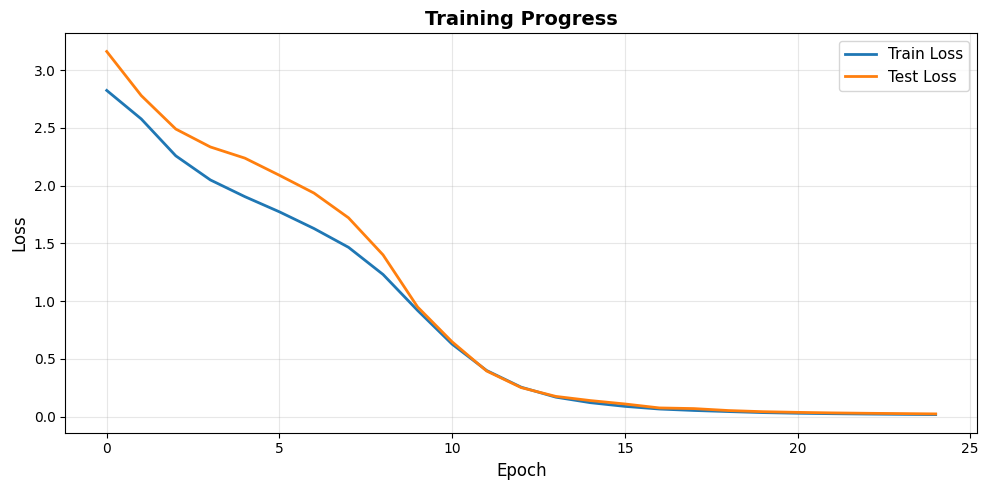

In [29]:
def train_epoch(model, data_input, data_target, optimizer, criterion, batch_size=32):
    model.train()
    epoch_loss = 0

    # Shuffle data
    indices = torch.randperm(len(data_input))

    for i in range(0, len(data_input), batch_size):
        batch_indices = indices[i:i+batch_size]
        src = data_input[batch_indices]
        trg = data_target[batch_indices]

        optimizer.zero_grad()

        # Forward pass
        output, _ = model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)


        # Compute loss (ignore first token which is START)
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)  # Skip START token

        loss = criterion(output, trg)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / (len(data_input) // batch_size)

def evaluate(model, data_input, data_target, criterion, batch_size=32):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i in range(0, len(data_input), batch_size):
            src = data_input[i:i+batch_size]
            trg = data_target[i:i+batch_size]

            output, _ = model(src, trg, teacher_forcing_ratio=0)

            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / (len(data_input) // batch_size)

# Training setup
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
num_epochs = 25
train_losses = []
test_losses = []

print("Training...")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_input, train_target, optimizer, criterion)
    test_loss = evaluate(model, test_input, test_target, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

print("\n✅ Training complete!")

# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.title('Training Progress', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part 7: Testing with Proper Inference

**KEY FIX:** The prediction function now:
1. ✅ Starts with START token (consistent with training!)
2. ✅ Generates until END token is produced
3. ✅ Has a max length safety check

In [30]:
def predict_with_attention(model, src_seq, start_token, end_token, max_length=20):
    """
    Generate output sequence and return attention weights.

    CRITICAL: Starts with START token, same as training!
    """
    model.eval()
    with torch.no_grad():
        src = src_seq.unsqueeze(0)  # Add batch dimension

        # Encode
        encoder_outputs, (hidden, cell) = model.encoder(src)

        # CRITICAL FIX: Initialize with START token (NOT src[:, 0]!)
        decoder_input = torch.LongTensor([[start_token]])

        predictions = []
        attention_weights = []

        # Generate until END token or max length
        for _ in range(max_length):
            output, hidden, cell, attn = model.decoder(
                decoder_input, hidden, cell, encoder_outputs
            )

            top1 = output.argmax(1)
            predicted_token = top1.item()

            predictions.append(predicted_token)
            attention_weights.append(attn.squeeze(0).cpu().numpy())

            # Stop if END token is generated
            if predicted_token == end_token:
                break

            decoder_input = top1.unsqueeze(1)

    return predictions, np.array(attention_weights)

# Test on several examples
print("\n" + "="*60)
print("Testing Model Predictions")
print("="*60)

num_examples = 5
correct_count = 0

for i in range(num_examples):
    test_seq = test_input[i]
    true_target = test_target[i]

    predictions, attention = predict_with_attention(
        model, test_seq, START_TOKEN, END_TOKEN
    )

    # Check if correct (excluding START, including END)
    is_correct = predictions == true_target[1:].tolist()[:len(predictions)]
    if is_correct:
        correct_count += 1

    print(f"\nExample {i+1}:")
    print(f"  Input:      {test_seq.tolist()}")
    print(f"  Predicted:  {predictions}")
    print(f"  True:       {true_target[1:].tolist()}  (excluding START token)")
    print(f"  ✅ CORRECT" if is_correct else f"  ❌ INCORRECT")

print(f"\n" + "="*60)
print(f"Accuracy: {correct_count}/{num_examples} = {100*correct_count/num_examples:.1f}%")
print("="*60)


Testing Model Predictions

Example 1:
  Input:      [2, 8, 11, 1, 6, 13, 6, 11]
  Predicted:  [11, 6, 13, 6, 1, 11, 8, 2, 17]
  True:       [11, 6, 13, 6, 1, 11, 8, 2, 17]  (excluding START token)
  ✅ CORRECT

Example 2:
  Input:      [4, 12, 11, 13, 15, 11, 13, 10]
  Predicted:  [10, 13, 11, 15, 13, 11, 12, 4, 17]
  True:       [10, 13, 11, 15, 13, 11, 12, 4, 17]  (excluding START token)
  ✅ CORRECT

Example 3:
  Input:      [3, 13, 11, 3, 15, 15, 13, 13]
  Predicted:  [13, 13, 15, 15, 3, 11, 13, 3, 17]
  True:       [13, 13, 15, 15, 3, 11, 13, 3, 17]  (excluding START token)
  ✅ CORRECT

Example 4:
  Input:      [1, 3, 4, 11, 11, 5, 3, 6]
  Predicted:  [6, 3, 5, 11, 11, 4, 3, 1, 17]
  True:       [6, 3, 5, 11, 11, 4, 3, 1, 17]  (excluding START token)
  ✅ CORRECT

Example 5:
  Input:      [11, 14, 15, 12, 5, 3, 6, 6]
  Predicted:  [6, 6, 3, 5, 12, 15, 14, 11, 17]
  True:       [6, 6, 3, 5, 12, 15, 14, 11, 17]  (excluding START token)
  ✅ CORRECT

Accuracy: 5/5 = 100.0%


## Part 8: Attention Visualization

This is the most exciting part! Let's visualize the attention weights.

**Expected pattern**: Reverse diagonal (output[0] attends to input[-1], etc.)


Attention Visualization

Input sequence:  [2, 8, 11, 1, 6, 13, 6, 11]
Output sequence: [11, 6, 13, 6, 1, 11, 8, 2, 17]

Note: A good model should show a REVERSE DIAGONAL pattern:
  - First output attends to LAST input
  - Second output attends to SECOND-TO-LAST input
  - etc.

Attention Heatmap:


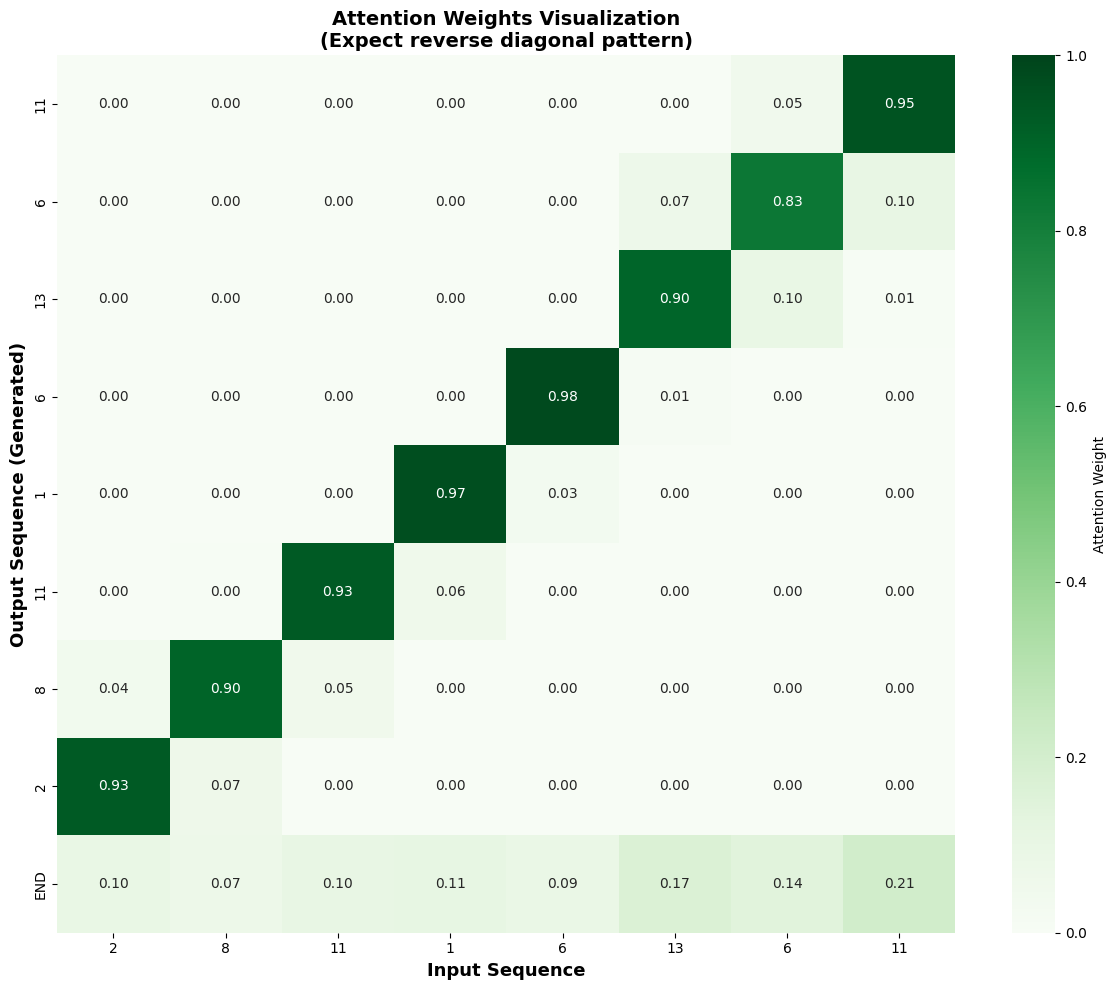

In [31]:
def visualize_attention(src_seq, predictions, attention_weights, start_token, end_token):
    """
    Create a heatmap of attention weights.
    """
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create labels
    src_labels = [str(x) for x in src_seq.tolist()]
    pred_labels = []
    for p in predictions:
        if p == start_token:
            pred_labels.append(f'START')
        elif p == end_token:
            pred_labels.append(f'END')
        else:
            pred_labels.append(str(p))

    # Create heatmap
    sns.heatmap(attention_weights,
                cmap='Greens',
                xticklabels=src_labels,
                yticklabels=pred_labels,
                cbar_kws={'label': 'Attention Weight'},
                annot=True,
                fmt='.2f',
                ax=ax,
                vmin=0,
                vmax=1)

    ax.set_xlabel('Input Sequence', fontsize=13, fontweight='bold')
    ax.set_ylabel('Output Sequence (Generated)', fontsize=13, fontweight='bold')
    ax.set_title('Attention Weights Visualization\n(Expect reverse diagonal pattern)',
                 fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Visualize attention for a good example
print("\n" + "="*60)
print("Attention Visualization")
print("="*60)

test_seq = test_input[0]
predictions, attention = predict_with_attention(
    model, test_seq, START_TOKEN, END_TOKEN
)

print(f"\nInput sequence:  {test_seq.tolist()}")
print(f"Output sequence: {predictions}")
print(f"\nNote: A good model should show a REVERSE DIAGONAL pattern:")
print(f"  - First output attends to LAST input")
print(f"  - Second output attends to SECOND-TO-LAST input")
print(f"  - etc.")
print(f"\nAttention Heatmap:")

visualize_attention(test_seq, predictions, attention, START_TOKEN, END_TOKEN)

## Questions and Tasks


1. **END token attention**: Why is attention more uniform/diffuse when generating the END token?

2. **Teacher Forcing**: Try changing teacher_forcing_ratio. What happens at 0? At 1?

3. **Softmax in the model**: The architecture calls for a softmax output layer (to choose the most likely next item in the sequence). But there is no call to softmax in the code. Explain.

1. **Compare with no attention**: Remove attention, use only final encoder state. How much worse is it?

5. **Improve the Translation task**: Change architecture from the previous notebook (translation) from simple LSTM to encoder-decoder ; apply attention mechanisms and observe if performance is better.

6. **Extra** Also apply this technique to the pronunciation task, and analyze results. I will post a cleaner, commented version of the pronunciation notebook shortly.

## Extra: Experimentos para as questões 2 e 4

## Extra: Experimento com `teacher_forcing_ratio`

Este bloco adiciona versões configuráveis das funções `train_epoch` e `evaluate`, além
de um laço de treinamento que permite testar diferentes valores de `teacher_forcing_ratio`
(por exemplo, 1.0, 0.5, 0.0) para responder à questão sobre *teacher forcing*.


Training with teacher_forcing_ratio = 0.5
Epoch 5/25 | TF=0.50 | Train Loss: 2.8951 | Test Loss: 3.3844
Epoch 10/25 | TF=0.50 | Train Loss: 2.8928 | Test Loss: 3.3844
Epoch 15/25 | TF=0.50 | Train Loss: 2.8954 | Test Loss: 3.3844
Epoch 20/25 | TF=0.50 | Train Loss: 2.8952 | Test Loss: 3.3844
Epoch 25/25 | TF=0.50 | Train Loss: 2.8952 | Test Loss: 3.3844

✅ Training complete!


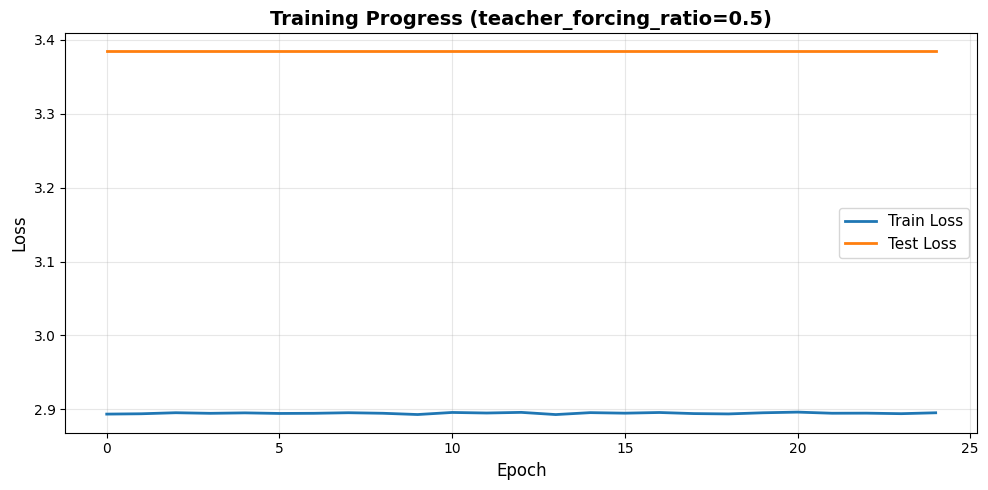

In [32]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_epoch(model, data_input, data_target, optimizer, criterion,
                batch_size=32, teacher_forcing_ratio=0.5):
    """
    Treina o modelo por 1 época, usando um teacher_forcing_ratio configurável.
    """
    model.train()
    epoch_loss = 0

    # Embaralha os índices para formar os batches
    indices = torch.randperm(len(data_input))

    for i in range(0, len(data_input), batch_size):
        batch_indices = indices[i:i+batch_size]
        src = data_input[batch_indices]
        trg = data_target[batch_indices]

        optimizer.zero_grad()

        # Forward: passa o teacher_forcing_ratio desejado
        output = model_noatt(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)

        # Calcula loss (ignorando o primeiro token [START])
        # output: (batch_size, trg_len-1, vocab_size)
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)        # (batch * (trg_len-1), vocab_size)
        trg = trg[:, 1:].reshape(-1)                   # (batch * (trg_len-1))

        loss = criterion(output, trg)
        loss.backward()

        # Gradient clipping para estabilidade
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / (len(data_input) // batch_size)


def evaluate(model, data_input, data_target, criterion, batch_size=32):
    """
    Avalia o modelo sem teacher forcing (teacher_forcing_ratio=0),
    simulando o comportamento de inferência.
    """
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i in range(0, len(data_input), batch_size):
            src = data_input[i:i+batch_size]
            trg = data_target[i:i+batchsize] if isinstance(batchsize := batch_size, int) else data_target[i:i+batch_size]

            # Na avaliação, teacher_forcing_ratio = 0
            output = model_noatt(src, trg, teacher_forcing_ratio=0.0)

            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / (len(data_input) // batch_size)


# ==== Exemplo de laço de treinamento com teacher_forcing_ratio configurável ====
# Atenção: assume que as variáveis abaixo já existem no notebook original:
# - model
# - train_input, train_target
# - test_input, test_target
# - TOTAL_VOCAB_SIZE, etc.

criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignora PAD=0
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
train_losses = []
test_losses = []

# Troque este valor para testar 1.0, 0.5, 0.0 etc.
teacher_forcing_ratio = 0.5

print("Training with teacher_forcing_ratio =", teacher_forcing_ratio)
for epoch in range(num_epochs):
    train_loss = train_epoch(
        model, train_input, train_target, optimizer, criterion,
        batch_size=32, teacher_forcing_ratio=teacher_forcing_ratio
    )
    test_loss = evaluate(model, test_input, test_target, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"TF={teacher_forcing_ratio:.2f} | "
              f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

print("\n✅ Training complete!")

# Plot da curva de treino
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.title(f'Training Progress (teacher_forcing_ratio={teacher_forcing_ratio})',
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Extra: Modelo Seq2Seq **sem atenção** para comparação

Este bloco implementa um decodificador e um modelo seq2seq **sem mecanismo de atenção**,
reutilizando o mesmo encoder do notebook original. Assim, é possível treinar esse modelo
e comparar o desempenho (loss de treino e teste) com o modelo **com atenção**.


Training model WITHOUT attention...
[NoAtt] Epoch 5/25 | Train Loss: 2.0568 | Test Loss: 2.3725
[NoAtt] Epoch 10/25 | Train Loss: 1.6514 | Test Loss: 2.0322
[NoAtt] Epoch 15/25 | Train Loss: 1.3639 | Test Loss: 1.7966
[NoAtt] Epoch 20/25 | Train Loss: 1.1419 | Test Loss: 1.5915
[NoAtt] Epoch 25/25 | Train Loss: 0.9429 | Test Loss: 1.4614


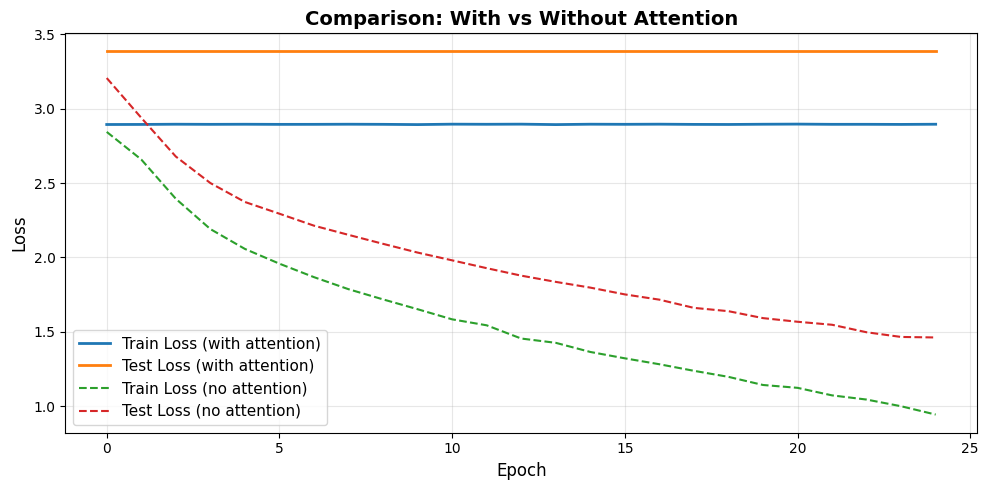

In [33]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# === Decoder sem atenção ===
class DecoderNoAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(DecoderNoAttention, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Entrada da LSTM é apenas o embedding (sem contexto de atenção)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_token, hidden, cell):
        """
        Args:
            input_token: (batch_size, 1) índice do token atual
            hidden, cell: estados da LSTM

        Returns:
            logits: (batch_size, vocab_size)
            hidden, cell: estados atualizados
        """
        # Embedding do token atual
        embedded = self.embedding(input_token)           # (batch, 1, emb_dim)

        # Passa pela LSTM
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        output = output.squeeze(1)                       # (batch, hidden_dim)

        # Logits para o próximo token
        logits = self.fc(output)                         # (batch, vocab_size)
        return logits, hidden, cell


# === Seq2Seq sem atenção ===
class Seq2SeqNoAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqNoAttention, self).__init__()
        # Reutiliza o Encoder já definido no notebook original
        self.encoder = Encoder(vocab_size, embedding_dim, hidden_dim)
        self.decoder = DecoderNoAttention(vocab_size, embedding_dim, hidden_dim)
        self.vocab_size = vocab_size

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        Args:
            src: (batch_size, src_len)
            trg: (batch_size, trg_len) - [START, reversed, END]
        Returns:
            outputs: (batch_size, trg_len-1, vocab_size)
        """
        batch_size, trg_len = trg.shape

        # Encode (usa apenas hidden/cell finais, ignora encoder_outputs)
        encoder_outputs, (hidden, cell) = self.encoder(src)

        # Inicializa o decoder com o START token (trg[:, 0])
        decoder_input = trg[:, 0].unsqueeze(1)           # (batch, 1)

        outputs = []

        for t in range(1, trg_len):
            # Decoder sem atenção
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)

            outputs.append(output)

            # Teacher forcing
            teacher_force = (torch.rand(1).item() < teacher_forcing_ratio)
            top1 = output.argmax(1)
            decoder_input = trg[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)

        outputs = torch.stack(outputs, dim=1)            # (batch, trg_len-1, vocab_size)
        return outputs


# ==== Treinando o modelo sem atenção para comparação ====

# Hiperparâmetros (pode ajustar para bater com os usados no modelo com atenção)
EMBEDDING_DIM = 32
HIDDEN_DIM = 64

model_noatt = Seq2SeqNoAttention(
    vocab_size=TOTAL_VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM
)

criterion_noatt = nn.CrossEntropyLoss(ignore_index=0)
optimizer_noatt = optim.Adam(model_noatt.parameters(), lr=0.001)

num_epochs_noatt = 25
train_losses_noatt = []
test_losses_noatt = []

print("Training model WITHOUT attention...")
for epoch in range(num_epochs_noatt):
    # forward sem atenção retorna apenas "output"
    output = model_noatt(train_input, train_target, teacher_forcing_ratio=0.5)

    train_loss = train_epoch(
        model_noatt, train_input, train_target,
        optimizer_noatt, criterion_noatt,
        batch_size=32, teacher_forcing_ratio=0.5
    )
    test_loss = evaluate(model_noatt, test_input, test_target, criterion_noatt)

    train_losses_noatt.append(train_loss)
    test_losses_noatt.append(test_loss)

    if (epoch + 1) % 5 == 0:
        print(f"[NoAtt] Epoch {epoch+1}/{num_epochs_noatt} | "
              f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


# Comparação visual (opcional)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (with attention)', linewidth=2)
plt.plot(test_losses, label='Test Loss (with attention)', linewidth=2)
plt.plot(train_losses_noatt, label='Train Loss (no attention)', linestyle='--')
plt.plot(test_losses_noatt, label='Test Loss (no attention)', linestyle='--')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.title('Comparison: With vs Without Attention', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
